In [12]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import zscore, spearmanr
from wordfreq import word_frequency
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl as op

In [7]:
def load_and_combine_dfs(output_dir: str = "outputs", 
                         ppl_dir: str = "perplexities") -> pd.DataFrame:
    all_dfs = []
    pps = []
    for ff in os.listdir(output_dir):
        if ".ipynb" not in ff and "distil" not in ff:
            df = pd.read_csv(f"{output_dir}/{ff}")
            #pp = pd.read_csv(f"{ppl_dir}/{ff.replace('.csv', '')}")
            #df["context_ppl"] = pp.context_pp
            #df["edit_ppl"] = pp.edit_context_pp
            all_dfs.append(df)
    return pd.concat(all_dfs)

In [15]:
# Information about warning here: https://stackoverflow.com/questions/54976991/python-openpyxl-userwarning-unknown-extension-issue
def extract_unique_words(morpholex_path):
    sheets = pd.read_excel(morpholex_path, sheet_name=None)
    
    words_from_sheets = []

    for sheet_name, data in sheets.items():
        if 'Word' in data.columns:
            words_from_sheets += data['Word'].dropna().unique().tolist()

    all_unique_words = set(str(word).lower() for word in words_from_sheets)

    return all_unique_words

morpholex = 'MorphoLEX_en.xlsx'  
english_words = extract_unique_words(morpholex)

/home/jacob/miniconda3/envs/pt/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/home/jacob/miniconda3/envs/pt/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/home/jacob/miniconda3/envs/pt/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/home/jacob/miniconda3/envs/pt/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/home/jacob/miniconda3/envs/pt/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/home

In [16]:
all_dfs = load_and_combine_dfs()
vocab = set(str(word).lower() for word in all_dfs.word)
is_eng = {word: word in english_words for word in vocab}

In [17]:
families = ("bert-", "roberta", "gpt2", "xlnet", "bloom")

for tt in families:
    all_dfs[tt.replace("-", "")] = all_dfs.model.apply(lambda x: tt in x)

all_dfs["is_eng"] = all_dfs.word.apply(lambda x: is_eng[str(x).lower()])
all_dfs["edit_is_eng"] = all_dfs.edit.apply(lambda x: str(x).lower() in vocab)
all_dfs["spearman_clean"] = all_dfs["spearman"].apply(lambda x: float(re.match(r'.+=(.+),', x).group(1)))
all_dfs["context_spearman_clean"] = all_dfs["context_spearman"].apply(lambda x: float(re.match(r'.+=(.+),', x).group(1)))
all_dfs["similarity"] = all_dfs["raw_distance"].apply(lambda x: -x + 1)
all_dfs["context_similarity"] = all_dfs["raw_context_distance"].apply(lambda x: -x + 1)
all_dfs["freq"] = all_dfs.word.apply(lambda x: word_frequency(str(x), "en"))
all_dfs["edit_freq"] = all_dfs.edit.apply(lambda x: word_frequency(str(x), "en"))
all_dfs["delta_len"] = all_dfs.edit_token_length - all_dfs.word_token_length

In [18]:
len(all_dfs[all_dfs.is_eng].word.unique()) # number of English words

40013

In [20]:
len(all_dfs.word.unique()) # Number of unique words

68725

In [21]:
all_dfs["similarity_difference"] = all_dfs["context_similarity"] - all_dfs["similarity"]
all_dfs["spearman_difference"] = all_dfs["context_spearman_clean"] - all_dfs["spearman_clean"]

In [25]:
palette = sns.color_palette("colorblind", n_colors=5)

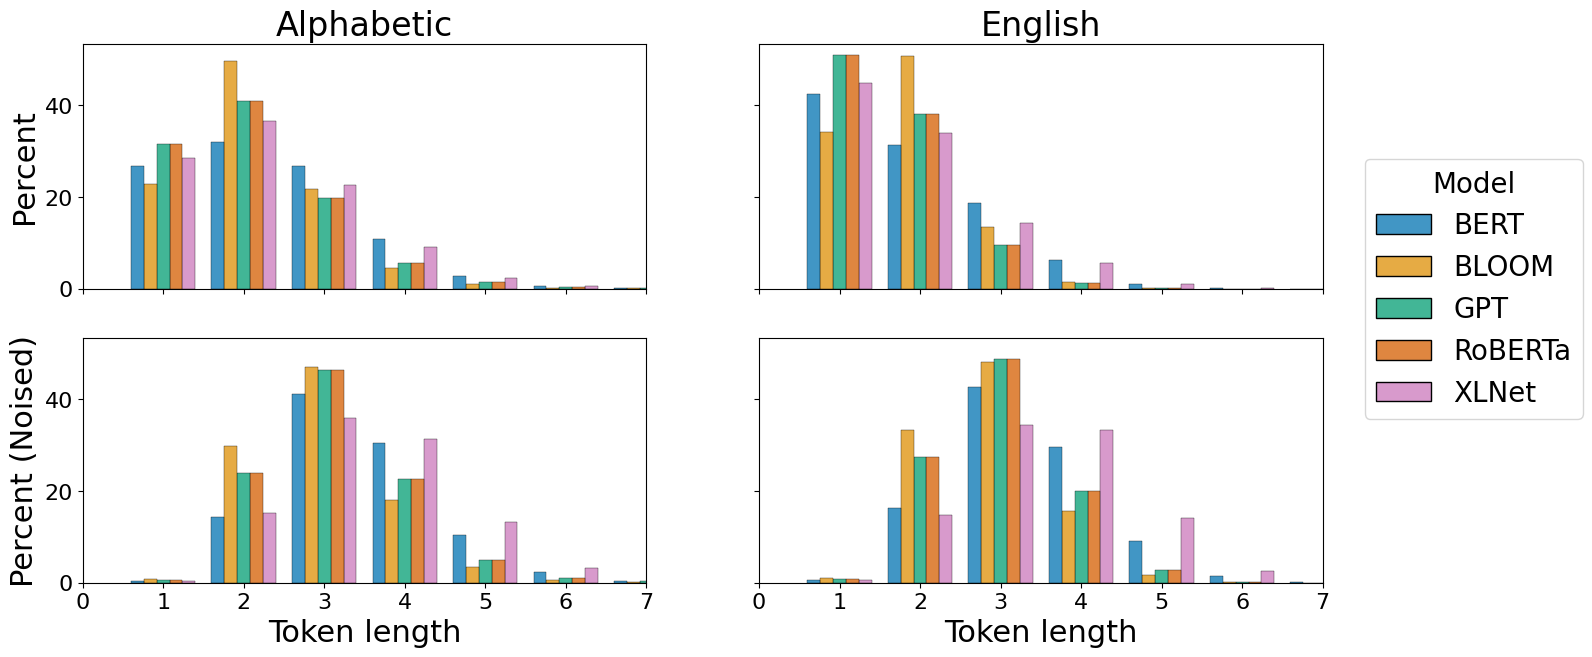

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(16, 7), sharey=True, sharex=True)
axs = axs.flatten()

data = all_dfs[all_dfs.model.isin({"bert-large-cased", "bigscience/bloom-560m", "gpt2-xl", "roberta-large", "xlnet-large-cased"})]
sns.histplot(
    data=data,
    x="word_token_length",
    hue="model",
    discrete=True,
    multiple="dodge",
    shrink=.8,
    stat="percent",
    common_norm=False,
    hue_order=sorted(data.model.unique()),
    ax=axs[0],
    legend=False,
    palette=palette
)

sns.histplot(
    data=data[data.is_eng],
    x="word_token_length",
    hue="model",
    discrete=True,
    multiple="dodge",
    shrink=.8,
    stat="percent",
    common_norm=False,
    hue_order=sorted(data[data.is_eng].model.unique()),
    ax=axs[1],
    legend=True,
    palette=palette
)

sns.histplot(
    data=data,
    x="edit_token_length",
    hue="model",
    discrete=True,
    multiple="dodge",
    shrink=.8,
    stat="percent",
    common_norm=False,
    hue_order=sorted(data.model.unique()),
    ax=axs[2],
    legend=False,
    palette=palette
)

sns.histplot(
    data=data[data.is_eng],
    x="edit_token_length",
    hue="model",
    discrete=True,
    multiple="dodge",
    shrink=.8,
    stat="percent",
    common_norm=False,
    hue_order=sorted(data[data.is_eng].model.unique()),
    ax=axs[3],
    legend=False,
    palette=palette
)


sns.move_legend(axs[1], 
                "center left", 
                bbox_to_anchor=(1.05, 0.0),
                title="Model",
                title_fontsize=20,
                fontsize=20, 
                labels=["BERT", "BLOOM", "GPT", "RoBERTa", "XLNet"])
#plt.legend(loc='center left', bbox_to_anchor=(1.01, .5), labels=sorted(all_dfs.model.unique()), reverse=True)


axs[0].set_ylabel("Percent", fontsize=22)
axs[0].tick_params(labelsize=16)
axs[0].set_title("Alphabetic", fontsize=24)
axs[1].set_title("English", fontsize=24)
axs[2].set_ylabel("Percent (Noised)", fontsize=22)
axs[2].set_xlabel("Token length", fontsize=22)
axs[2].tick_params(labelsize=16)
axs[3].set_xlabel("Token length", fontsize=22)
axs[3].tick_params(labelsize=16)
axs[0].set_xlim(0, 7)
axs[1].set_xlim(0, 7)


plt.show()

([<matplotlib.axis.XTick at 0x7fc749a12010>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

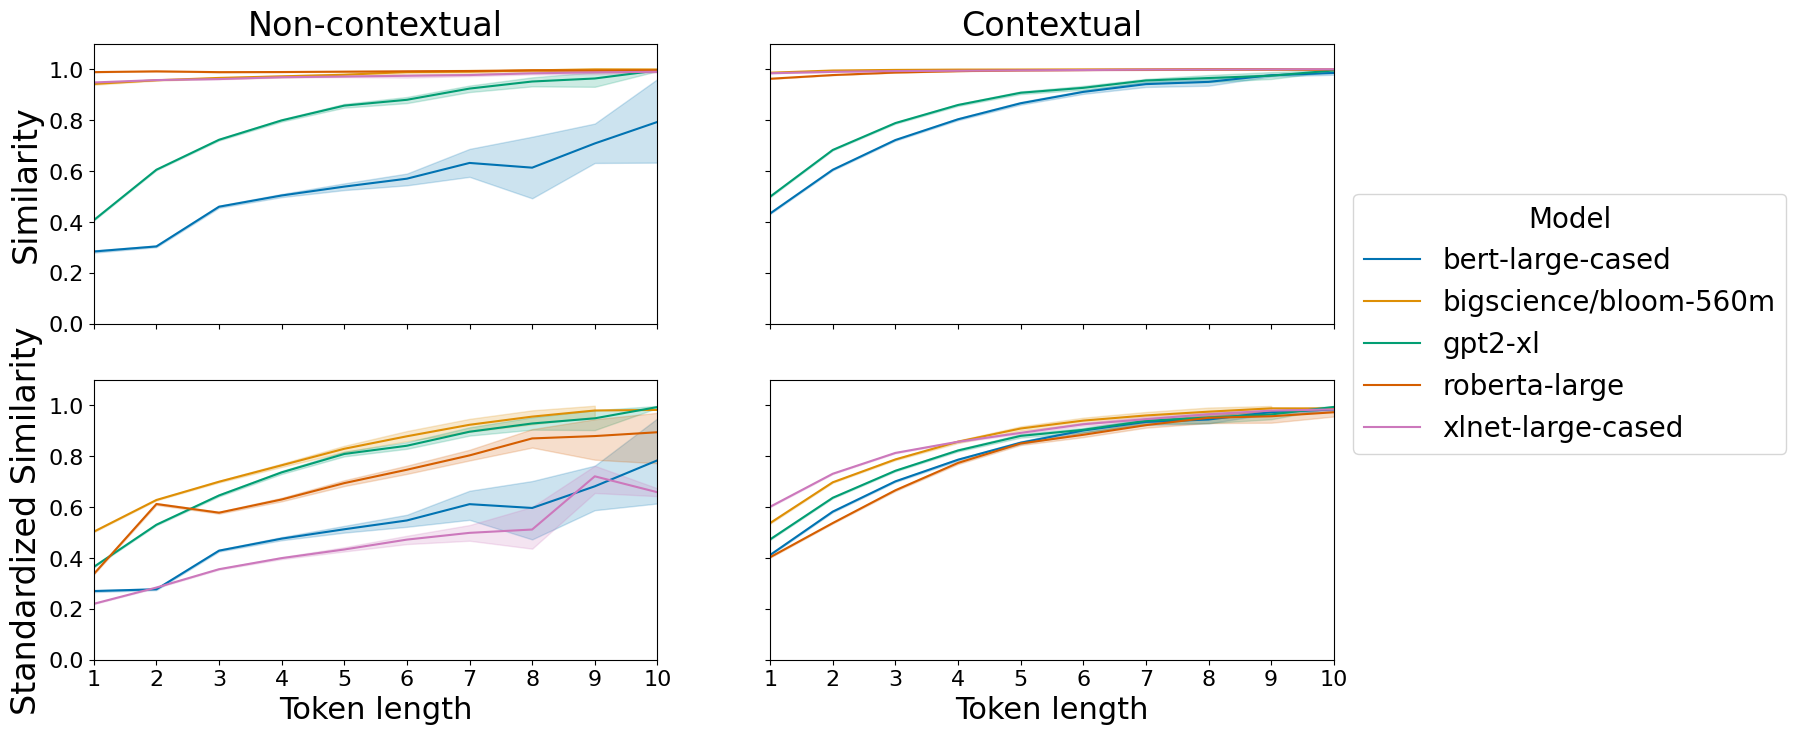

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
axs = axs.flatten()
metrics = ["similarity", "context_similarity", "spearman_clean", "context_spearman_clean"] 
ys = ["Similarity",
      "",
      "Standardized Similarity",
      ""]
for i, ax in enumerate(axs):
    leg = True if i == 1 else False
    sns.lineplot(
        data=data,
        x="word_token_length", 
        y=metrics[i],
        hue="model", 
        legend=leg, 
        ax=ax,
        hue_order=sorted(data.model.unique()),
        errorbar=("ci", 99),
        n_boot=500,
        palette=palette
    )
    if i == 0: 
        ax.set_title("Non-contextual", fontsize=24)
    if i == 1:
        ax.set_title("Contextual", fontsize=24)
    ax.tick_params(labelsize=16)
    ax.set_ylabel(ys[i], fontsize=24)
    ax.set_xlim(1, 10)
    if i < 2:
        ax.set_ylim(0.0, 1.1)
    else:
        ax.set_ylim(0.0, 1.1)
        ax.set_xlabel("Token length", fontsize=22)

sns.move_legend(axs[1], 
                "center left", 
                bbox_to_anchor=(1.01, 0.0), 
                fontsize=20, 
                title="Model",
                title_fontsize=20)

plt.xticks(list(range(1, 11)))

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
axs = axs.flatten()
metrics = ["similarity", "context_similarity", "spearman_clean", "context_spearman_clean"] 
ys = ["Similarity",
      "",
      "Standardized Similarity",
      ""]
for i, ax in enumerate(axs):
    leg = True if i == 1 else False
    sns.lineplot(
        data=all_dfs,
        x="word_token_length", 
        y=metrics[i],
        hue="model", 
        legend=leg, 
        ax=ax,
        hue_order=sorted(all_dfs.model.unique()),
        errorbar=("ci", 99),
        n_boot=500,
        palette=palette
    )
    if i == 0: 
        ax.set_title("Non-contextual", fontsize=24)
    if i == 1:
        ax.set_title("Contextual", fontsize=24)
    ax.tick_params(labelsize=18)
    ax.set_ylabel(ys[i], fontsize=24)
    ax.set_xlim(1, 10)
    if i < 2:
        ax.set_ylim(0.0, 1.1)
    else:
        ax.set_ylim(0.0, 1.1)
        ax.set_xlabel("Token length", fontsize=22)

sns.move_legend(axs[1], 
                "center left", 
                bbox_to_anchor=(1.01, 0.0), 
                fontsize=20, 
                title="Model",
                title_fontsize=20)

plt.xticks(list(range(1, 11)))

/tmp/ipykernel_75920/2387185201.py:16: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_75920/2387185201.py:16: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_75920/2387185201.py:16: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_75920/2387185201.py:16: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(


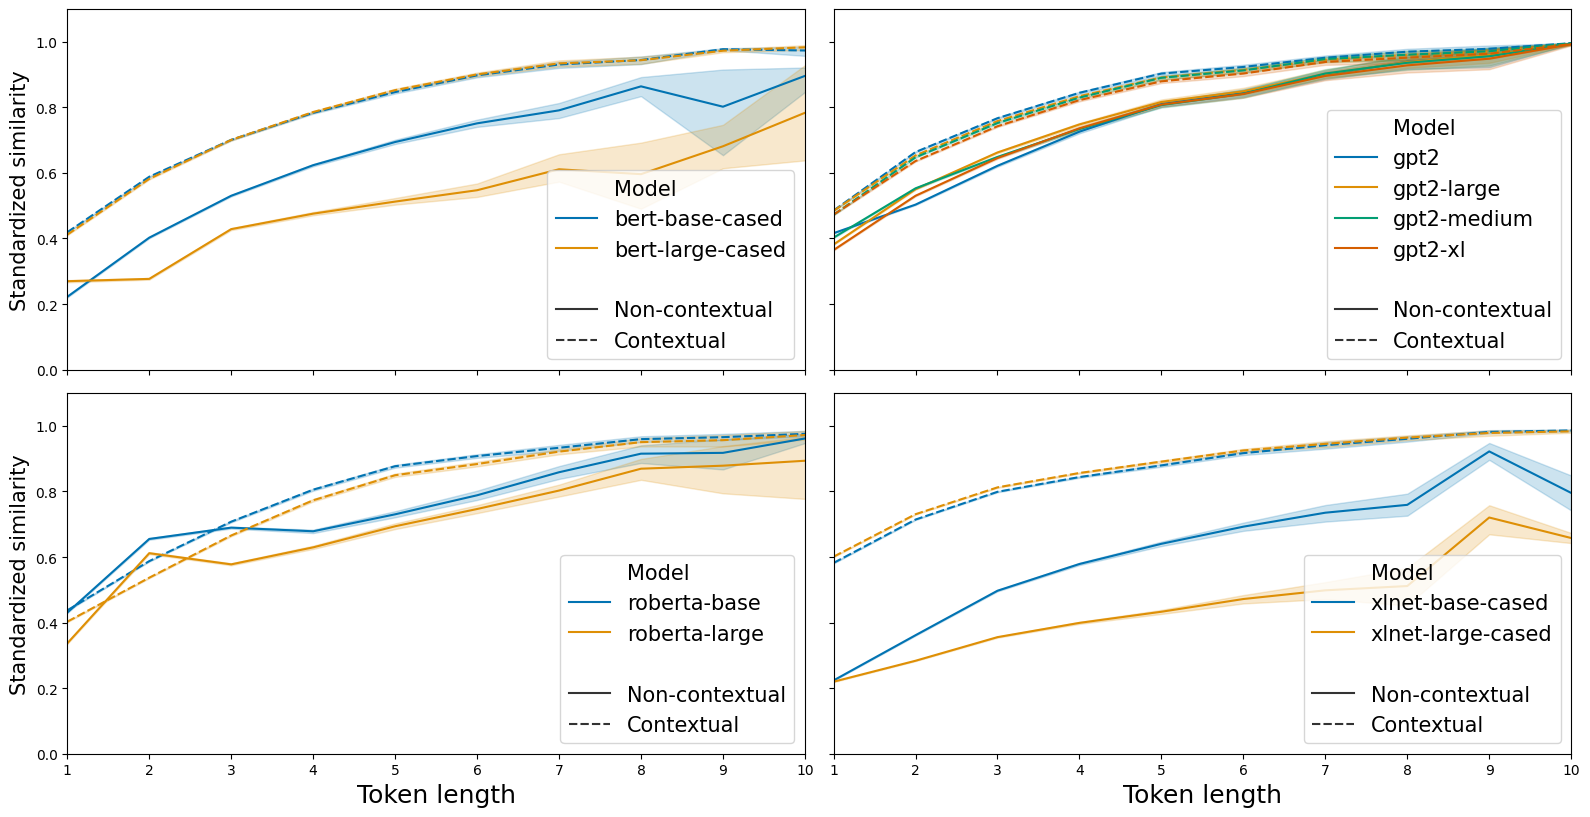

In [107]:
melted = all_dfs.melt(id_vars=["word", "model", "word_token_length", "bert", "gpt2", "roberta", "xlnet"], 
                      value_vars=["context_spearman_clean", "spearman_clean"], var_name="type")
melted["Contextual"] = melted["type"] == "context_spearman_clean"

fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey=True)
melted = melted.rename({"model": "Model"}, axis=1)

axs = axs.flatten()
model_type = ["bert", "gpt2", "roberta", "xlnet"]
palette = sns.color_palette("colorblind")  

for i, ax in enumerate(axs):
    # Data for the current model type
    data = melted[melted[model_type[i]]]

    sns.lineplot(
        data=data,
        x="word_token_length",
        y="value",
        hue="Model",
        hue_order=sorted(data['Model'].unique()),
        style="Contextual",
        markers=False, 
        dashes=True,  
        ax=ax,
        palette=palette
    )
    
    ax.set_ylabel("Standardized similarity", size=15)
    ax.set_xlim(1, 10)
    ax.set_ylim(0.0, 1.1)
    h, l = ax.get_legend_handles_labels()
    new_labels = {"Contextual": "", "True": "Contextual", "False": "Non-contextual"}
    l = [new_labels.get(i, i) for i in l]
    ax.legend(h, l, fontsize=15)
    if i > 1:
        ax.set_xlabel("Token length", size=18)
    else:
        ax.set_xlabel("")
#fig.suptitle("Standardized similarity", fontsize=16)
plt.xticks(list(range(1, 11)))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


/tmp/ipykernel_75920/2388036330.py:16: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_75920/2388036330.py:16: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_75920/2388036330.py:16: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_75920/2388036330.py:16: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(


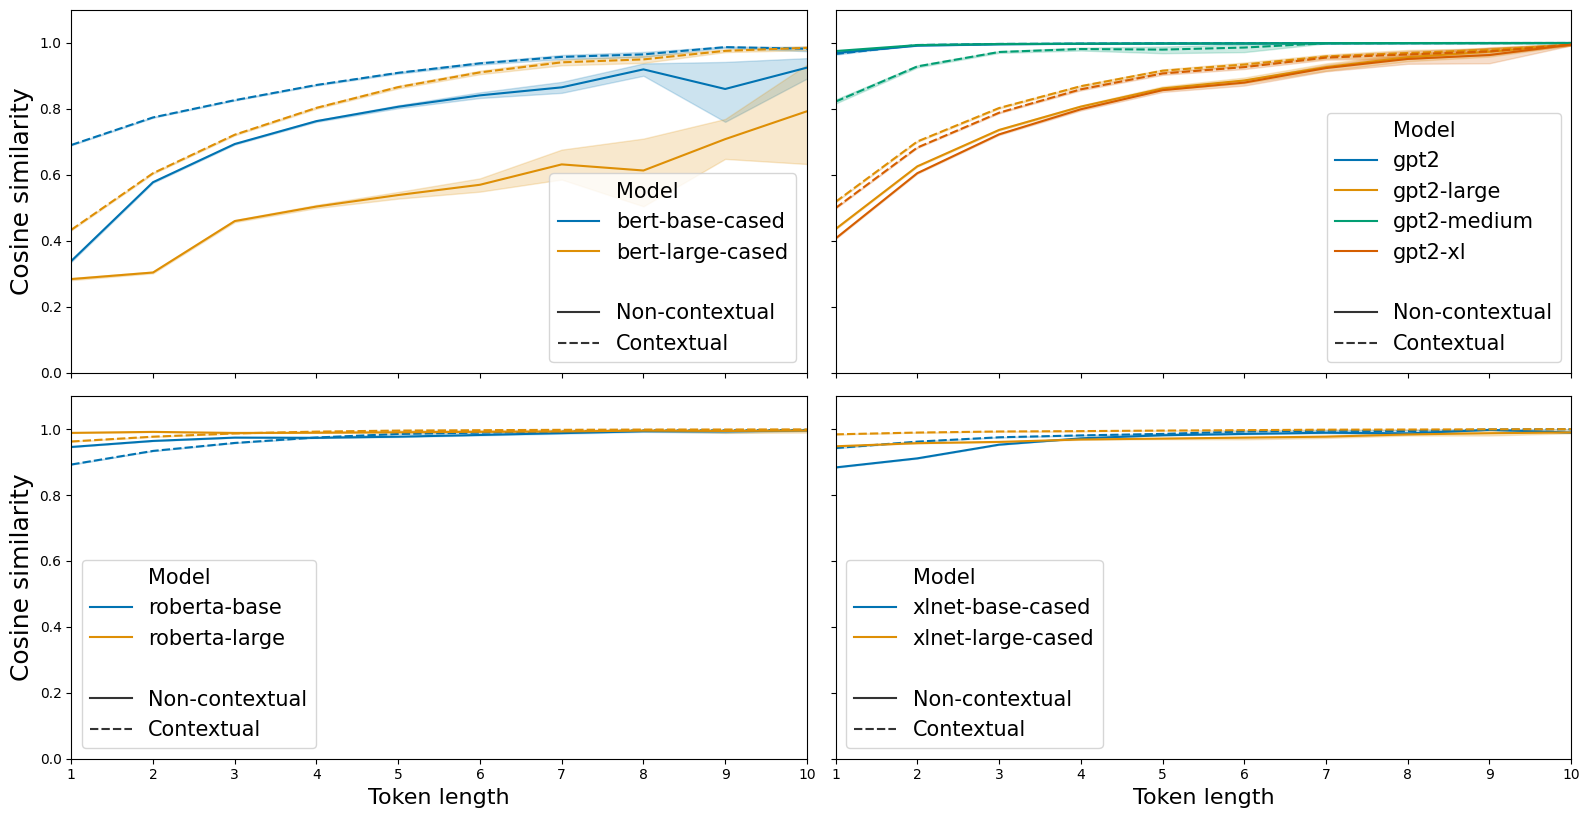

In [108]:
melted = all_dfs.melt(id_vars=["word", "model", "word_token_length", "bert", "gpt2", "roberta", "xlnet"], 
                      value_vars=["similarity", "context_similarity"], var_name="type")
melted["Contextual"] = melted["type"] == "context_similarity"
melted = melted.rename({"model": "Model"}, axis=1)

fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey=True)

axs = axs.flatten()
model_type = ["bert", "gpt2", "roberta", "xlnet"]
palette = sns.color_palette("colorblind")  

for i, ax in enumerate(axs):
    # Data for the current model type
    data = melted[melted[model_type[i]]]

    sns.lineplot(
        data=data,
        x="word_token_length",
        y="value",
        hue="Model",
        hue_order=sorted(data['Model'].unique()),
        style="Contextual",
        markers=False, 
        dashes=True,  
        ax=ax,
        palette=palette
    )

    ax.set_ylabel("Cosine similarity", size=18)
    ax.set_xlim(1, 10)
    ax.set_ylim(0.0, 1.1)
    h, l = ax.get_legend_handles_labels()
    new_labels = {"Contextual": "", "True": "Contextual", "False": "Non-contextual"}
    l = [new_labels.get(i, i) for i in l]
    ax.legend(h, l, fontsize=15)
    if i > 1:
        ax.set_xlabel("Token length", size=16)
    else:
        ax.set_xlabel("")
#fig.suptitle("Standardized similarity", fontsize=16)
plt.xticks(list(range(1, 11)))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()
